Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import SGD
import numpy as np
import matplotlib.pyplot as plt

import os

2024-07-10 09:50:09.732794: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-10 09:50:09.734268: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-10 09:50:09.766286: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-10 09:50:09.767642: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-10 09:50:10.363032: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Dataset Configuration

In [14]:
batch_size = 16


train_ds = tf.keras.utils.image_dataset_from_directory(
    os.getcwd() + '/Train',
    image_size=(128,128),
    batch_size=batch_size,
    label_mode = 'categorical'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.getcwd() + '/Test',
    image_size=(128,128),
    batch_size=batch_size,
    label_mode = 'categorical'
)

Found 660 files belonging to 7 classes.
Found 207 files belonging to 7 classes.


In [30]:
num_classes = len(train_ds.class_names)


Dataset Visualization

['Coffee', 'Corn', 'Eucalyptus', 'Goiaba', 'Orange', 'Soybean', 'Tomato']


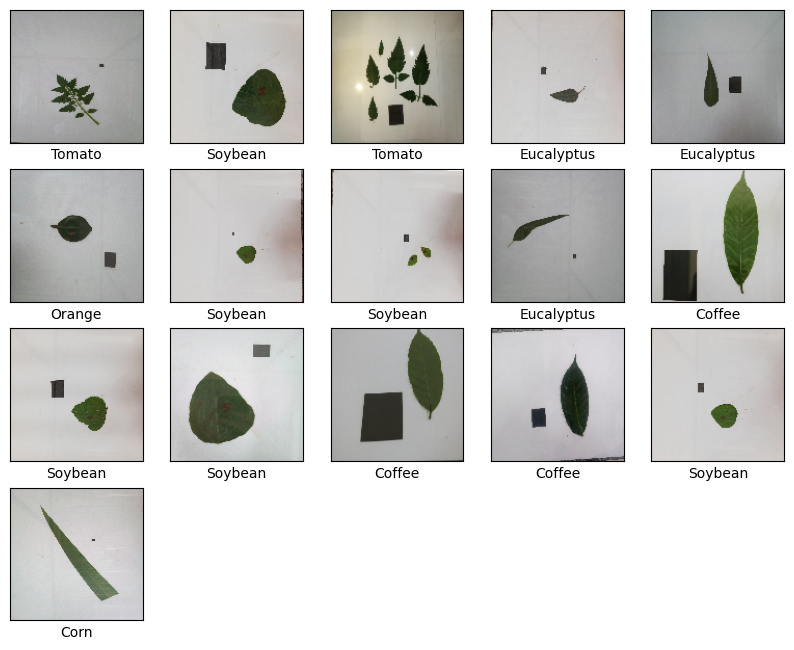

In [3]:
class_names = train_ds.class_names

print(class_names)

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(16):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.xlabel(class_names[tf.math.argmax(labels[i])])
  plt.show()

Normalizing Dataset

In [4]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

Model

In [5]:
image_shape = (128, 128, 3)
# image_shape = (1920, 2560, 3)

# # LeNet-5
# model = Sequential([
#             Conv2D(6, 5, activation='relu', input_shape=image_shape),
#             MaxPooling2D(strides=(2,2)),
#             Conv2D(16, 5, activation='relu'),
#             MaxPooling2D(strides=(2,2)),
#             Flatten(),
#             Dense(120, activation='relu'),
#             Dropout(0.5),
#             Dense(84, activation='relu'),
#             Dropout(0.5),
#             Dense(7, activation='softmax')
# ])

# AlexNet
model = Sequential([
            Conv2D(96, 11, strides=(4,4), activation='relu', input_shape=image_shape),
            MaxPooling2D(pool_size=(3,3), strides=(2,2)),
            Conv2D(256, 5, padding='same', activation='relu'),
            MaxPooling2D(pool_size=(3,3), strides=(2,2)),
            Conv2D(384, 3, padding='same', activation='relu'),
            Conv2D(384, 3, padding='same', activation='relu'),
            Conv2D(256, 3, padding='same', activation='relu'),
            MaxPooling2D(pool_size=(3,3), strides=(2,2)),
            Flatten(),
            Dense(4096, activation='relu'),
            Dropout(0.5),
            Dense(4096, activation='relu'),
            Dropout(0.5),
            Dense(7, activation='softmax')
])

# # VGG-16
# model = Sequential([
#             Conv2D(64, 3, padding='same', activation='relu', input_shape=image_shape),
#             Conv2D(64, 3, padding='same', activation='relu'),
#             MaxPooling2D(pool_size=(2,2), strides=(2,2)),
#             Conv2D(128, 3, padding='same', activation='relu'),
#             Conv2D(128, 3, padding='same', activation='relu'),
#             MaxPooling2D(pool_size=(2,2), strides=(2,2)),
#             Conv2D(256, 3, padding='same', activation='relu'),
#             Conv2D(256, 3, padding='same', activation='relu'),
#             Conv2D(256, 3, padding='same', activation='relu'),
#             MaxPooling2D(pool_size=(2,2), strides=(2,2)),
#             Conv2D(512, 3, padding='same', activation='relu'),
#             Conv2D(512, 3, padding='same', activation='relu'),
#             Conv2D(512, 3, padding='same', activation='relu'),
#             MaxPooling2D(pool_size=(2,2), strides=(2,2)),
#             Conv2D(512, 3, padding='same', activation='relu'),
#             Conv2D(512, 3, padding='same', activation='relu'),
#             Conv2D(512, 3, padding='same', activation='relu'),
#             MaxPooling2D(pool_size=(2,2), strides=(2,2)),
#             Flatten(),
#             Dense(4096, activation='relu'),
#             Dropout(0.5),
#             Dense(4096, activation='relu'),
#             Dropout(0.5),
#             Dense(7, activation='softmax')
# ])

# # Inception
# model = Sequential([
#             Conv2D(64, 7, strides=(2,2), padding='same', activation='relu', input_shape=image_shape),
#             MaxPooling2D(pool_size=(3,3), strides=(2,2)),
#             Conv2D(64, 1, activation='relu'),
#             Conv2D(192, 3, padding='same', activation='relu'),
#             MaxPooling2D(pool_size=(3,3), strides=(2,2)),
#             Conv2D(64, 1, activation='relu'),
#             Conv2D(128, 3, padding='same', activation='relu'),
#             Conv2D(256, 3, padding='same', activation='relu'),
#             MaxPooling2D(pool_size=(3,3), strides=(2,2)),
#             Conv2D(128, 1, activation='relu'),
#             Conv2D(192, 3, padding='same', activation='relu'),
#             Conv2D(256, 3, padding='same', activation='relu'),
#             MaxPooling2D(pool_size=(3,3), strides=(2,2)),
#             Conv2D(256, 1, activation='relu'),
#             Conv2D(384, 3, padding='same', activation='relu'),
#             Conv2D(256, 3, padding='same', activation='relu'),
#             Conv2D(256, 3, padding='same', activation='relu'),
#             MaxPooling2D(pool_size=(3,3), strides=(2,2)),
#             Flatten(),
#             Dense(4096, activation='relu'),
#             Dropout(0.5),
#             Dense(4096, activation='relu'),
#             Dropout(0.5),
#             Dense(7, activation='softmax')
# ])


model.compile(optimizer=SGD(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 256)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 384)         885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 6, 6, 384)         1

TRAINING

In [6]:
history = model.fit(train_ds, epochs=10)

train_acc = history.history["accuracy"]
train_loss = history.history["loss"]


Epoch 1/10
42/42 [==============================] - 8s 157ms/step - loss: 2.7555 - accuracy: 0.1924 - categorical_accuracy: 0.1924
Epoch 2/10
42/42 [==============================] - 7s 151ms/step - loss: 1.8641 - accuracy: 0.1924 - categorical_accuracy: 0.1924
Epoch 3/10
42/42 [==============================] - 7s 150ms/step - loss: 1.8504 - accuracy: 0.2167 - categorical_accuracy: 0.2167
Epoch 4/10
42/42 [==============================] - 7s 153ms/step - loss: 1.8173 - accuracy: 0.2500 - categorical_accuracy: 0.2500
Epoch 5/10
42/42 [==============================] - 7s 149ms/step - loss: 1.7791 - accuracy: 0.2970 - categorical_accuracy: 0.2970
Epoch 6/10
42/42 [==============================] - 7s 148ms/step - loss: 1.7302 - accuracy: 0.3136 - categorical_accuracy: 0.3136
Epoch 7/10
42/42 [==============================] - 7s 147ms/step - loss: 1.6680 - accuracy: 0.3288 - categorical_accuracy: 0.3288
Epoch 8/10
42/42 [==============================] - 9s 192ms/step - loss: 1.5820 - 

Testing

In [7]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1)

print('\nTest accuracy:', test_acc)

13/13 [==============================] - 2s 54ms/step - loss: 1.4337 - accuracy: 0.4831 - categorical_accuracy: 0.4831

Test accuracy: 0.483091801404953


Plotting

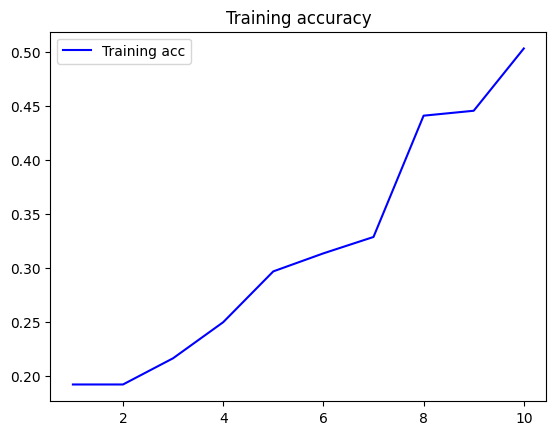

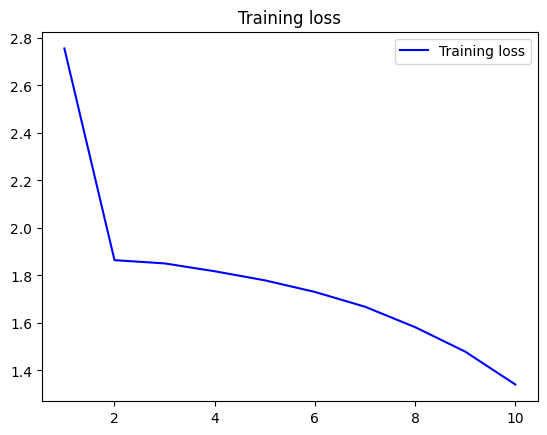

In [8]:
epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'b', label='Training acc')
plt.title('Training accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.show()